<a href="https://colab.research.google.com/github/sabriwi/polyglot/blob/master/Interrogating_BERT_1_Classification_Using_for_Damani_VOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interrogating BERT (Classification)

By Peter Usherwood, 

Adpated from the official tutorial found here https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb


# 0.0 Intro

BERT is currently one of (if not top of the) leaders in NLP transfer learning. To get a full picture on what BERT is I reccomend refering to the original paper https://arxiv.org/abs/1810.04805 or this excellent blog post on the NLP transfer learning zoo http://jalammar.github.io/illustrated-bert/. Here we going through a more technical user guide of how to do transfer learning with BERT. The target audience for this is data scientists who understand a bit of tensorflow/python/nlp/deep learning already.

This "tutorial" is split into 2 notebooks, this is the first where we shall see how BERT works by looking at doing a simple classification transfer learning task. However I have dedicated a whole second notebook to understanding how to use BERT for sequence to sequence tasks (specifically question answering with a Facebook dataset) because in my opinion it is such a maaaaaaaassive pain it needs a whole extra notebook. However I wont re-cover things in here in that one so please read both :)

The purpose of this notebook/tutorial is interrogate BERT to understand exactly what he is, how he works, and how we can use him. Here a lot of this notebook is based on the official tutorial for BERT, and we do use the official BERT library, however.... whenever the BERT library boilerplate is used to hide what is going on we pull it apart to understand exactly what is going on at each stage and how we 'could' modify it. The goal here is to give a comprehensive technical tutorial for transfer learning with BERT so that we can use it in the most project/data agnostic way possible, after we could go back to using boilerplate or not depending on our project. As such you will see the phrase 'BERT black box' used quite disparagingly here, however it is more used as a reference point for where were attempting to de-mistify the high level apis.

Now when I say comprehensive technical tutorial, I am still treating this from the transfer learning side, I am not here diving down into how the core net works, just fully understanding the inputs, how we join the core net into a bigger model, how we train and evaluate it, and how we can use all of that in a pipeline. 

I built this tutorial based on the great official one found here, if you just want a quick working example I reccomend reading that instead (this one's more wordy) https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

Now not all of the high level apis here are BERTs fault, and they may not even be vexing to you. Specifically Estimators and Tensorflow Hub are used extensively here. These are not super new but new enough that they were confusing to me, as such I will lightly tackle these at the same time, particularaly in places where the BERT black box overlaps so we fully appriciate whats going on.

- NOTE: Connecting to hub can be a problem on some Kantar networks, if the code in tokenizer or model hangs, take your laptop home and try there.
- NOTE: You need Tensorflow 1.11.0> for BERT
- NOTE: Unless you've got a nice graphics card, probably its best to upload this and the data to colab and run it there
- NOTE: it is important to remember BERT is not a person when you read this notebook

# 0.1 How fat is BERT?

This is a key question, it's all well and good understanding the thoery or the technical detail but if we cant run BERT on are hardware it's not much good. So how fat is he? Well unfortunately... quite. As said on the official github repo:

"Important: All results on the paper were fine-tuned on a single Cloud TPU, which has 64GB of RAM. It is currently not possible to re-produce most of the BERT-Large results on the paper using a GPU with 12GB - 16GB of RAM, because the maximum batch size that can fit in memory is too small. We are working on adding code to this repository which allows for much larger effective batch size on the GPU. See the section on out-of-memory issues for more details.

This code was tested with TensorFlow 1.11.0. It was tested with Python2 and Python3 (but more thoroughly with Python2, since this is what's used internally in Google).

The fine-tuning examples which use BERT-Base should be able to run on a GPU that has at least 12GB of RAM using the hyperparameters given."

To put this in perspective most mid-range laptops with GPUs will have about 4GB VRAM (as per mine). And the best "reasonable" consumer graphics card you'd buy is the RTX 2080Ti which has 11GB and costs like $1200 (if you live in the US, where I am its like 2000). Now google colab do allow you to have up to I think its about 12GB VRAM so you can run BERT-small there (which is what im doing in this tutorial), but its important to bare this in mind when making producing classifiers with BERT.

# 0.2 How fast is BERT?

So to train the base language model in BERT is quite slow, as expected its a huge transformer neural net that runs forward and back passes and does next sentence prediction. As per the published paper:

"Training of BERTBASE was performed on 4
Cloud TPUs in Pod configuration (16 TPU chips
total).5 Training of BERTLARGE was performed
on 16 Cloud TPUs (64 TPU chips total). Each pretraining took 4 days to complete."

However thats not really the focus of this tutorial (although something to bare in mind if you were thinking of training a BERT in a different language). Here we're focusing more on transfer learning using a pre-trained BERT and the good news here is it is quite fast. Training the classification example here with 1500 labeled examples only takes of the order 5-10 minutes, and this should scale linearly with number of examples (you could obviously up the number of epochs too). So in conclusion once you have the base, BERT is quite fast, if you have a graphics card that can hold him training time is not an issue.

# 0.3 How good is BERT at school?

Anybody thats been following NLP knows BERT got SOTAs across the board on various language tasks, one thing of particular interest is that the architecture allows for seq -> seq tasks as well as classification which makes it more felixble than some of the others (ULMFiT for example). One thing that is not fully clear to me yet is how good BERT (or indeed other transfer learning techniques) are when put under "extreme" conditions, for example low shot learning, dirty or noisy text data like social, how good they are going cross domain etc. Im looking into this, but thats for another time, all that is important for now is, it seems BERT is one of the best at NLP ML problems today.

# 0.4 How do we make him dance?

This is the main purpose of this repo, its understanding how BERT works and how we can use it to build out useful classifiers and seq -> seq tasks. As per the official tutorial we start by looking at a classification problem (this notebook), although here we use trinary data and not binary and a different dataset (Yelp) to ensure things are agnostic as possible. After we will look at seq -> seq for contextual question answering (in the second notebook)

In [0]:
%tensorflow_version 1.x

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub # pip install tensorflow-hub
from datetime import datetime

In [3]:
!pip install bert-tensorflow
import bert # pip install bert-tensorflow
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [4]:
# Only run this if your doing this on colab, you will have to upload the data to drive too
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1.0 Data

First we get some data, nothing here is BERT specific, just getting any old classification data, this comes from Yelp and has been balanced and only 1, 3, and 5 star reviews are included

In [0]:
# df_trn = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/yelp/balanced/train.csv")
# df_val = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/yelp/balanced/validate.csv")
# df_tst = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/yelp/balanced/test.csv")

# df_trn = pd.read_csv("./yelp/balanced/train.csv")
# df_val = pd.read_csv("./yelp/balanced/validate.csv")
# df_tst = pd.read_csv("./yelp/balanced/test.csv")

# print(df_trn["label"].value_counts())
# print(df_val["label"].value_counts())
# print(df_tst["label"].value_counts())

# print(df_trn['text'].dtype)
# print(df_val['text'].dtype)
# print(df_tst['text'].dtype)

Train on reviews, test on reviews:

{'eval_accuracy': 0.71499175, 'global_step': 5593, 'loss': 0.96274084}, training takes about 45 minutes on GPU

Train on twitter, test on twitter:

{'eval_accuracy': 0.74233335, 'global_step': 1125, 'loss': 0.7972801}, 
31 minutes to train

Train on reviews, test on twitter:

{'eval_accuracy': 0.528, 'global_step': 5593, 'loss': 1.2526485}



Train on twitter, test on reviews:

{'eval_accuracy': 0.5837452, 'global_step': 1125, 'loss': 1.2252384}


In [5]:
# from pathlib import Path
# data_path = Path("K:/R&D/Projects/NLP PROJECT/data/english-large/")
# df_trn = pd.read_csv(data_path / "train.csv")
# df_tst = pd.read_csv(data_path / "test.csv")
# print(df_trn['is_valid'].value_counts())

# df_trn = pd.read_csv("/content/gdrive/My Drive/DeepLearning/english-large/train.csv")
# df_tst = pd.read_csv("/content/gdrive/My Drive/DeepLearning/english-large/test.csv")

df_trn = pd.read_csv("/content/gdrive/My Drive/DeepLearning/english-large/tweet_train.csv")
df_tst = pd.read_csv("/content/gdrive/My Drive/DeepLearning/english-large/tweet_test.csv")


df_val = df_trn[df_trn['is_valid']]
df_trn = df_trn[~df_trn['is_valid']]


# print(df_trn["label"].value_counts())
# print(df_val["label"].value_counts())
# print(df_tst["label"].value_counts())

# translate [-1, 0, 1] into [1,3,5] (just in case it changes anything)
# def translate(x):
#     if x == 1: return 5
#     if x == 0: return 3
#     if x == -1: return 1
    
# df_trn['label'] = df_trn['label'].apply(translate)
# df_val['label'] = df_val['label'].apply(translate)
# df_tst['label'] = df_tst['label'].apply(translate)
    
print(df_trn["label"].value_counts())
print(df_val["label"].value_counts())
print(df_tst["label"].value_counts())

print(df_trn['text'].dtype)
print(df_val['text'].dtype)
print(df_tst['text'].dtype)


df_trn['text'] = df_trn['text'].astype('str')
df_val['text'] = df_val['text'].astype('str')
df_tst['text'] = df_tst['text'].astype('str')



# Sampling down to yelp numbers and balancing at the same time:
# each class has these number of instances 524 train, 75 validate, 150 test

# sizes:
train_size = 524
val_size = 75
test_size = 150
# {'eval_accuracy': 0.62666667, 'global_step': 147, 'loss': 1.1610295}, training takes about 2 minutes on GPU

# min size to keep in balanced:
# train: 19887, val: 4093, test: 607
# {'eval_accuracy': 0.71499175, 'global_step': 5593, 'loss': 0.96274084}, training takes about 45 minutes on GPU

g = df_trn.groupby('label')
# df_trn = g.apply(lambda x: x.sample(n=train_size, random_state=1).reset_index(drop=True))
df_trn = g.apply(lambda x: x.sample(n=g.size().min(), random_state=1).reset_index(drop=True))

g = df_val.groupby('label')
# df_val = g.apply(lambda x: x.sample(n=val_size, random_state=1).reset_index(drop=True))
df_val = g.apply(lambda x: x.sample(n=g.size().min(), random_state=1).reset_index(drop=True))

g = df_tst.groupby('label')
# df_tst = g.apply(lambda x: x.sample(n=test_size, random_state=1).reset_index(drop=True))
df_tst = g.apply(lambda x: x.sample(n=g.size().min(), random_state=1).reset_index(drop=True))

print(df_trn["label"].value_counts())
print(df_val["label"].value_counts())
print(df_tst["label"].value_counts())


-1    4000
 1    4000
 0    4000
Name: label, dtype: int64
 1    500
 0    500
-1    500
Name: label, dtype: int64
 1    1000
-1    1000
 0    1000
Name: label, dtype: int64
object
object
object
-1    4000
 1    4000
 0    4000
Name: label, dtype: int64
 1    500
 0    500
-1    500
Name: label, dtype: int64
 1    1000
-1    1000
 0    1000
Name: label, dtype: int64


Make sure we shuffle the data here or BERT fails

In [6]:
df_trn = df_trn[["text", "label"]]
df_tst = df_tst[["text", "label"]]

df_trn = df_trn.sample(frac=1)
df_tst = df_tst.sample(frac=1)

df_trn.sample(n=10)

text  label
label                                                               
 1    2814  Don't miss the beast Brock Lesnar on ESPN tomo...      1
 0    3264  Ellen returns with new season Tuesday, intervi...      0
      3449  Check Out #Omen from @disclosure ft. Sam Smith...      0
-1    909               Dustin Johnson just can't do Sunday's     -1
 1    435   Good driving/singing tunes The Bee Gees, might...      1
      1848  I feel like Dustin Johnson always  has the lea...      1
 0    136   @Giggles5050 @DrGarekar I think Patels along w...      0
      2722  Lady Gaga appeared to momentarily regret her c...      0
      2952  Part of me thinks Nicki is so serious about he...      0
      2430  Remember this when you watch the news stories ...      0

For us, our input data is the 'sentence' column and our label is the 'polarity' column (0, 1 for negative and positive, respecitvely)

In [0]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
# label_list = [1, 3, 5]
label_list = [-1, 0, 1]

# 2.0 Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves three steps:
- First, we create  `InputExample`'s using the constructor provided in the BERT library.
- Second, we load the model specific tokenizer
- Third, we convert examples to features BERT understands using parts 1 and 2

# 2.1 Input Features

These classes are super simple and litterally just have 4 attributes that hold the text. What info they hold is listed below.


- `text_a` is the text we want to classify, which in this case, is the `text` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [0]:
train_InputExamples = df_trn.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = df_tst.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

## Understanding what BERT eats

Now this is an ok explination to operate BERT basically, but if we want to really understand what is going inside we need to fully approciate theoretically what BERT wants for its inputs (this part is key for lots of later discussion to). And BERTs input representation is not intuitive (in my opinion).

First we can mention how it wants its inputs ordered. 

It can take up to 512 tokens in a single 'sequence'. A sequence is defined as one input example (however that may be constructed). Note this limit on 512 is actually very important when we come to look at question answering.

Said sequence is composed in one of two ways as best described by comments in the oficial repo...

The convention in BERT is:

(a) For sequence pairs:

tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]

(b) For single sequences:

tokens:   [CLS] the dog is hairy . [SEP]

So depending on if we're doing single sequence or sequence to sequence we arrange the data in one of these two ways. Note BERT refer to the whole input as the sequence, and each of the two potential parts as sentences even though they can be longer or shorter than a linguistic sentence.

Next we have to understand what BERT does with these words, goes to word embeddings? We'll yes but not so simply...

![image.png](attachment:image.png)

BERT actually sums 3 different embeddings, however as we shall see we only actually need to create the ids for the word embeddings and the segment embeddings as inputs to the model. Creating the positional embeddings, gettings the vectors, and summing is all done internally, and in this notebook we're not messing with core BERT.

# 2.1 Tokenizer

Next, we need to preprocess our data so that it matches the data BERT was trained on.This follows the following process.


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Now the original blog says "Happily, we don't have to worry about most of these details.", and simply instanciates an instance of the bert.tokenization.FullTokenizer class... but I want to go deeper.

So lets look at BERTs tokenizer setup:

```
######################### SOURCE CODE ###############################
class FullTokenizer(object):
  """Runs end-to-end tokenziation."""

  def __init__(self, vocab_file, do_lower_case=True):
    self.vocab = load_vocab(vocab_file)
    self.inv_vocab = {v: k for k, v in self.vocab.items()}
    self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)
    self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)

  def tokenize(self, text):
    split_tokens = []
    for token in self.basic_tokenizer.tokenize(text):
      for sub_token in self.wordpiece_tokenizer.tokenize(token):
        split_tokens.append(sub_token)

    return split_tokens

  def convert_tokens_to_ids(self, tokens):
    return convert_by_vocab(self.vocab, tokens)

  def convert_ids_to_tokens(self, ids):
    return convert_by_vocab(self.inv_vocab, ids)
######################### SOURCE CODE ###############################
```

This above code is taken directly from their repository, as we can see the tokenizer has all the basic components we'd expect. 

- vocab is a dictionary that maps ids to words in the input vocab (familiar to anyone acustomed to working with language models)
- inv_vocab is the oposite, words to ids
- they then have two tokenizers, one is a more basic form and the other splits out word parts, they could have grouped the two

Now this is simple enoguh, however the "recomended" way of instanciating this is (to me) super confusing!!! (See below)

In [9]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"


"""Get the vocab file and casing info from the Hub module."""
with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                              tokenization_info["do_lower_case"]])
        
tokenizer = bert.tokenization.FullTokenizer(vocab_file=vocab_file, 
                                            do_lower_case=do_lower_case)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


So... what happened?

Well here we are using Tensorflow Hub, which is Tensorflows newest way of easily sharing pre-trained models, its vital to understand this for anyone doing transfer learning in TF. The BERT model was loaded in the deafult graph (standard Tensorflow) from Hub https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1 by calling a set filepath into hub.Module. As such to go any further we really need to understand exactly what the hub.Module returns, and how we get at the underlying module. To start the official docs https://www.tensorflow.org/hub/api_docs/python/hub/Module are actually quite good on Module.__init__:

######################### OFFICIAL DOCS ###############################

Constructs a Module to be used in the current graph.

This creates the module state-graph under an unused variable_scope based on name. During this call a Module will:

Add GLOBAL_VARIABLES under its scope. Those variables may be added to to the TRAINABLE_VARIABLES collection (depending on trainable parameter) and to the MODEL_VARIABLES. The variables must be initialized before use, and can be checkpointed as usual.

Add ops to the INIT_TABLE_OPS collection, which must be run during session initialization and add constant tensors to ASSET_FILEPATHS that are needed during the execution of such ops.

Add tensors to the REGULARIZATION_LOSSES collection (depending on trainable parameter).

Args:
- spec: A ModuleSpec defining the Module to instantiate or a path where to load a ModuleSpec from via load_module_spec.
- trainable: whether the Module is trainable. If False, no variables are added to TRAINABLE_VARIABLES collection, and no tensors are added to REGULARIZATION_LOSSES collection.
- name: A string, the variable scope name under which to create the Module. It will be uniquified and the equivalent name scope must be unused.
- tags: A set of strings specifying the graph variant to use.

######################### OFFICIAL DOCS ###############################

Thats reasonably clear (for tensorflow) we now have all of the variables of the BERT graph defined under a specific variable scope. It also added these to some dictionaries of what variables exist (for example trainable parameters). Finally it adds the operations to the INIT_TABLE_OPS.

So now I have at least 3 questions (maybe inquisitive you has many more :))... 
- How do we access the variables? Can we modify the graph? 
- How do we call it? In what way is it being called?
- What in the world are these next 3 lines!?!?

    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    
    with tf.Session() as sess:
    
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
                                            
To help with these im drawing a lot of inspiration from this tutorial that you should definetly check out https://medium.com/ymedialabs-innovation/how-to-use-tensorflow-hub-with-code-examples-9100edec29af.

So to start with once we have the instance it is called using a 'signature'. Whats a signature? Well the signatures are pre-defined use cases for how the creator wants the user to call their model. We can see the available signatures by running:

In [10]:
bert_module.get_signature_names()

['mlm', 'tokens', 'tokenization_info']

Well now we have these abstracted use cases, but what do we need to give to them? And what do they output? As is the case with BERT this is documented on tf hub, they only actually support the 'tokens' signature... (even though we're using the tokenization_info one here...), however we can check by running:

In [11]:
print(bert_module.get_input_info_dict(signature='tokens'))
print(bert_module.get_output_info_dict(signature='tokens'))

print(bert_module.get_input_info_dict(signature='tokenization_info'))
print(bert_module.get_output_info_dict(signature='tokenization_info'))

{'segment_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'input_mask': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'input_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>}
{'sequence_output': <hub.ParsedTensorInfo shape=(?, ?, 768) dtype=float32 is_sparse=False>, 'pooled_output': <hub.ParsedTensorInfo shape=(?, 768) dtype=float32 is_sparse=False>}
{}
{'do_lower_case': <hub.ParsedTensorInfo shape=() dtype=bool is_sparse=False>, 'vocab_file': <hub.ParsedTensorInfo shape=() dtype=string is_sparse=False>}


So given what we know about what BERT eats and the output we'd expect from a language model, 'tokens' seems to make sense in what it does, that is the main running process. However thats section 3. Here lets look more at 'tokenization_info', 'tokenization_info' doesnt take any inputs (makes sense as the tokenization should depend only on the model and not on the inputs), and gives two outputs: the vocab file and if we should lower everything... makes sense.

Now this business makes sense:
```
tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
with tf.Session() as sess:
    vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                        tokenization_info["do_lower_case"]])
```                                           
As tokenization_info (the variable) here is a pointer to two tensors in the graph, each of which are called and their output returned, noramlly in session.run we'd pass the input as well but we already know for these specific endpoints there are no inputs. Now session.run will run the pretrained graph and these two endpoints will give us what we need.

I havn't addressed the accessing and messing with the main graph yet, I think that makes more sense in the model section where as it turns out we need to reload the model from tf hub in the same way, so for now we'll continue just knowning how to call the model and what it returns.

So back to the original tutorial... "we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:"

In [12]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

Now to add a bit of "whats going on" we can easily parse the vocab attribute (that we saw earlier as part of the tokenizer) to a pandas df to view the vocabulary

In [13]:
vocab_df = pd.DataFrame(np.array([list(tokenizer.vocab.keys()), list(tokenizer.vocab.values())]).T, columns=["Vocab", "ID"])
vocab_df.sample(n=10)

,Vocab,ID
11173,iris,11173
9545,fountain,9545
3479,selected,3479
122,[unused117],122
10046,glacier,10046
11586,din,11586
11848,toilet,11848
13698,alps,13698
4516,documentary,4516
952,[unused947],952


In [14]:
print(len(bert_module.variable_map))
tokenization_info['do_lower_case']

204


<tf.Tensor 'module_apply_tokenization_info/Const:0' shape=() dtype=bool>

# 2.3 Examples to Features

Next.... Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands. Now we know that BERT is hoping for inputs of the form:

In [15]:
print(bert_module.get_input_info_dict(signature='tokens'))

{'segment_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'input_mask': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'input_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>}


But as is this is completely black box as to what is happening here! Let's look

In [16]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 12000


INFO:tensorflow:Writing example 0 of 12000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] tonight going to see foo fighters in concert + friday ken ##ney che ##s ##ney : ) ) [SEP]


INFO:tensorflow:tokens: [CLS] tonight going to see foo fighters in concert + friday ken ##ney che ##s ##ney : ) ) [SEP]


INFO:tensorflow:input_ids: 101 3892 2183 2000 2156 29379 7299 1999 4164 1009 5958 6358 5420 18178 2015 5420 1024 1007 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3892 2183 2000 2156 29379 7299 1999 4164 1009 5958 6358 5420 18178 2015 5420 1024 1007 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 2)


INFO:tensorflow:label: 1 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] w ##th , only hulk hogan blocked me during my # celebrity ##sl ##ander ##sat ##ur ##day ? i guess it ' s still saturday . round two ! [SEP]


INFO:tensorflow:tokens: [CLS] w ##th , only hulk hogan blocked me during my # celebrity ##sl ##ander ##sat ##ur ##day ? i guess it ' s still saturday . round two ! [SEP]


INFO:tensorflow:input_ids: 101 1059 2705 1010 2069 16009 14851 8534 2033 2076 2026 1001 8958 14540 12243 16846 3126 10259 1029 1045 3984 2009 1005 1055 2145 5095 1012 2461 2048 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1059 2705 1010 2069 16009 14851 8534 2033 2076 2026 1001 8958 14540 12243 16846 3126 10259 1029 1045 3984 2009 1005 1055 2145 5095 1012 2461 2048 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i ' m honestly really satisfied with my classes except 3rd but it ' s gu ##cci [SEP]


INFO:tensorflow:tokens: [CLS] i ' m honestly really satisfied with my classes except 3rd but it ' s gu ##cci [SEP]


INFO:tensorflow:input_ids: 101 1045 1005 1049 9826 2428 8510 2007 2026 4280 3272 3822 2021 2009 1005 1055 19739 14693 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 1005 1049 9826 2428 8510 2007 2026 4280 3272 3822 2021 2009 1005 1055 19739 14693 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 2)


INFO:tensorflow:label: 1 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] fuck that next fight floyd may ##weather got next saturday night . it ' s going to be weak as hell [SEP]


INFO:tensorflow:tokens: [CLS] fuck that next fight floyd may ##weather got next saturday night . it ' s going to be weak as hell [SEP]


INFO:tensorflow:input_ids: 101 6616 2008 2279 2954 12305 2089 28949 2288 2279 5095 2305 1012 2009 1005 1055 2183 2000 2022 5410 2004 3109 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6616 2008 2279 2954 12305 2089 28949 2288 2279 5095 2305 1012 2009 1005 1055 2183 2000 2022 5410 2004 3109 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: -1 (id = 0)


INFO:tensorflow:label: -1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] kamal ##a , who defended hulk hogan following the racial ti ##rade scandal that broke out on friday , discussed the . . . http : / / t . co / 9 ##c ##j ##x ##9 ##n ##wo ##5 ##o [SEP]


INFO:tensorflow:tokens: [CLS] kamal ##a , who defended hulk hogan following the racial ti ##rade scandal that broke out on friday , discussed the . . . http : / / t . co / 9 ##c ##j ##x ##9 ##n ##wo ##5 ##o [SEP]


INFO:tensorflow:input_ids: 101 21911 2050 1010 2040 8047 16009 14851 2206 1996 5762 14841 13662 9446 2008 3631 2041 2006 5958 1010 6936 1996 1012 1012 1012 8299 1024 1013 1013 1056 1012 2522 1013 1023 2278 3501 2595 2683 2078 12155 2629 2080 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 21911 2050 1010 2040 8047 16009 14851 2206 1996 5762 14841 13662 9446 2008 3631 2041 2006 5958 1010 6936 1996 1012 1012 1012 8299 1024 1013 1013 1056 1012 2522 1013 1023 2278 3501 2595 2683 2078 12155 2629 2080 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: -1 (id = 0)


INFO:tensorflow:label: -1 (id = 0)


INFO:tensorflow:Writing example 10000 of 12000


INFO:tensorflow:Writing example 10000 of 12000


INFO:tensorflow:Writing example 0 of 3000


INFO:tensorflow:Writing example 0 of 3000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] # bono hand delivered pizza to fans waiting in ga line for the u2 concert tomorrow . this band is the definition of awesome . # u2 # u2 ##ie ##tour [SEP]


INFO:tensorflow:tokens: [CLS] # bono hand delivered pizza to fans waiting in ga line for the u2 concert tomorrow . this band is the definition of awesome . # u2 # u2 ##ie ##tour [SEP]


INFO:tensorflow:input_ids: 101 1001 23648 2192 5359 10733 2000 4599 3403 1999 11721 2240 2005 1996 23343 4164 4826 1012 2023 2316 2003 1996 6210 1997 12476 1012 1001 23343 1001 23343 2666 21163 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1001 23648 2192 5359 10733 2000 4599 3403 1999 11721 2240 2005 1996 23343 4164 4826 1012 2023 2316 2003 1996 6210 1997 12476 1012 1001 23343 1001 23343 2666 21163 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 2)


INFO:tensorflow:label: 1 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] josh hamilton 2 run blast ! rangers lead the giants 2 - 0 in the 6th ! # never ##ever ##qui ##t [SEP]


INFO:tensorflow:tokens: [CLS] josh hamilton 2 run blast ! rangers lead the giants 2 - 0 in the 6th ! # never ##ever ##qui ##t [SEP]


INFO:tensorflow:input_ids: 101 6498 5226 1016 2448 8479 999 7181 2599 1996 7230 1016 1011 1014 1999 1996 5351 999 1001 2196 22507 15549 2102 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6498 5226 1016 2448 8479 999 7181 2599 1996 7230 1016 1011 1014 1999 1996 5351 999 1001 2196 22507 15549 2102 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 2)


INFO:tensorflow:label: 1 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i wish i could buy something but he doesn ' t ship to israel . . . https : / / t . co / hd ##df ##8 ##8 ##uo ##c ##j [SEP]


INFO:tensorflow:tokens: [CLS] i wish i could buy something but he doesn ' t ship to israel . . . https : / / t . co / hd ##df ##8 ##8 ##uo ##c ##j [SEP]


INFO:tensorflow:input_ids: 101 1045 4299 1045 2071 4965 2242 2021 2002 2987 1005 1056 2911 2000 3956 1012 1012 1012 16770 1024 1013 1013 1056 1012 2522 1013 10751 20952 2620 2620 19098 2278 3501 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 4299 1045 2071 4965 2242 2021 2002 2987 1005 1056 2911 2000 3956 1012 1012 1012 16770 1024 1013 1013 1056 1012 2522 1013 10751 20952 2620 2620 19098 2278 3501 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hey , did you know national ice cream day is sunday , july 19th ? make sure you take a moment to enjoy a scoop of your favorite flavor ! # yu ##m [SEP]


INFO:tensorflow:tokens: [CLS] hey , did you know national ice cream day is sunday , july 19th ? make sure you take a moment to enjoy a scoop of your favorite flavor ! # yu ##m [SEP]


INFO:tensorflow:input_ids: 101 4931 1010 2106 2017 2113 2120 3256 6949 2154 2003 4465 1010 2251 3708 1029 2191 2469 2017 2202 1037 2617 2000 5959 1037 23348 1997 2115 5440 14894 999 1001 9805 2213 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4931 1010 2106 2017 2113 2120 3256 6949 2154 2003 4465 1010 2251 3708 1029 2191 2469 2017 2202 1037 2617 2000 5959 1037 23348 1997 2115 5440 14894 999 1001 9805 2213 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 2)


INFO:tensorflow:label: 1 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] @ matt ##fo ##ssen @ frank ##con ##ni ##ff 1st , they did do plan 9 . 2nd , shark ##nad ##o is not earnest ##ly bad , it ' s ironically so . that ' s why ms ##t ##3 ##k wouldn ' t work [SEP]


INFO:tensorflow:tokens: [CLS] @ matt ##fo ##ssen @ frank ##con ##ni ##ff 1st , they did do plan 9 . 2nd , shark ##nad ##o is not earnest ##ly bad , it ' s ironically so . that ' s why ms ##t ##3 ##k wouldn ' t work [SEP]


INFO:tensorflow:input_ids: 101 1030 4717 14876 14416 1030 3581 8663 3490 4246 3083 1010 2027 2106 2079 2933 1023 1012 3416 1010 11420 25389 2080 2003 2025 17300 2135 2919 1010 2009 1005 1055 18527 2061 1012 2008 1005 1055 2339 5796 2102 2509 2243 2876 1005 1056 2147 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1030 4717 14876 14416 1030 3581 8663 3490 4246 3083 1010 2027 2106 2079 2933 1023 1012 3416 1010 11420 25389 2080 2003 2025 17300 2135 2919 1010 2009 1005 1055 18527 2061 1012 2008 1005 1055 2339 5796 2102 2509 2243 2876 1005 1056 2147 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: -1 (id = 0)


INFO:tensorflow:label: -1 (id = 0)


Right.... lets have a look at exactly what happened there by again looking at the source code.

######################### SOURCE CODE ###############################
```
# This function is not used by this file but is still used by the Colab and
# people who depend on it.
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer):
  """Convert a set of `InputExample`s to a list of `InputFeatures`."""

  features = []
  for (ex_index, example) in enumerate(examples):
    if ex_index % 10000 == 0:
      tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))

    feature = convert_single_example(ex_index, example, label_list,
                                     max_seq_length, tokenizer)

    features.append(feature)
  return features
```
######################### SOURCE CODE ###############################

So lets have a look whats happening here...
Inputs:
- examples - it is taking as input our list of classes as "examples", where each class just has 4 arributes that hold the relevant info (guid, text_a, text_b, label)
- label_list - our python list with the values of the labels for our classification task
- max_sequence_length - Integer, a hyperparameter of how many steps (word parts) we want to analyse, common hyperparameter for those of us familiar with language modelling
- tokenizer -  the custom tokenizer class that holds the vocab and methods for tokenizing text.

So whats the method doing? Well its simply looping through each example (doing a bit of logging) and then appending a simple converted example to a python list before returning the list. This single example depends on all the things above but now also has an index. Lets look at the source code for convert_single_example...

######################### SOURCE CODE ###############################
```
def convert_single_example(ex_index, example, label_list, max_seq_length,
                           tokenizer):
  """Converts a single `InputExample` into a single `InputFeatures`."""

  if isinstance(example, PaddingInputExample):
    return InputFeatures(
        input_ids=[0] * max_seq_length,
        input_mask=[0] * max_seq_length,
        segment_ids=[0] * max_seq_length,
        label_id=0,
        is_real_example=False)

  label_map = {}
  for (i, label) in enumerate(label_list):
    label_map[label] = i

  tokens_a = tokenizer.tokenize(example.text_a)
  tokens_b = None
  if example.text_b:
    tokens_b = tokenizer.tokenize(example.text_b)

  if tokens_b:
    # Modifies `tokens_a` and `tokens_b` in place so that the total
    # length is less than the specified length.
    # Account for [CLS], [SEP], [SEP] with "- 3"
    _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
  else:
    # Account for [CLS] and [SEP] with "- 2"
    if len(tokens_a) > max_seq_length - 2:
      tokens_a = tokens_a[0:(max_seq_length - 2)]

  # The convention in BERT is:
  # (a) For sequence pairs:
  #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
  #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
  # (b) For single sequences:
  #  tokens:   [CLS] the dog is hairy . [SEP]
  #  type_ids: 0     0   0   0  0     0 0
  #
  # Where "type_ids" are used to indicate whether this is the first
  # sequence or the second sequence. The embedding vectors for `type=0` and
  # `type=1` were learned during pre-training and are added to the wordpiece
  # embedding vector (and position vector). This is not *strictly* necessary
  # since the [SEP] token unambiguously separates the sequences, but it makes
  # it easier for the model to learn the concept of sequences.
  #
  # For classification tasks, the first vector (corresponding to [CLS]) is
  # used as the "sentence vector". Note that this only makes sense because
  # the entire model is fine-tuned.
  tokens = []
  segment_ids = []
  tokens.append("[CLS]")
  segment_ids.append(0)
  for token in tokens_a:
    tokens.append(token)
    segment_ids.append(0)
  tokens.append("[SEP]")
  segment_ids.append(0)

  if tokens_b:
    for token in tokens_b:
      tokens.append(token)
      segment_ids.append(1)
    tokens.append("[SEP]")
    segment_ids.append(1)

  input_ids = tokenizer.convert_tokens_to_ids(tokens)

  # The mask has 1 for real tokens and 0 for padding tokens. Only real
  # tokens are attended to.
  input_mask = [1] * len(input_ids)

  # Zero-pad up to the sequence length.
  while len(input_ids) < max_seq_length:
    input_ids.append(0)
    input_mask.append(0)
    segment_ids.append(0)

  assert len(input_ids) == max_seq_length
  assert len(input_mask) == max_seq_length
  assert len(segment_ids) == max_seq_length

  label_id = label_map[example.label]
  if ex_index < 5:
    tf.logging.info("*** Example ***")
    tf.logging.info("guid: %s" % (example.guid))
    tf.logging.info("tokens: %s" % " ".join(
        [tokenization.printable_text(x) for x in tokens]))
    tf.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
    tf.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
    tf.logging.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
    tf.logging.info("label: %s (id = %d)" % (example.label, label_id))

  feature = InputFeatures(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids,
      label_id=label_id,
      is_real_example=True)
  return feature
```
######################### SOURCE CODE ###############################

This is a bit more involved (i.e. long) but its actually quite transparent what they're doing if we break it down. So lets start by remembering what we mentioned earlier around how the BERT model want to read its inputs. BERT wants inputs in the form:

(a) For sequence pairs:

tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]

(b) For single sequences:

tokens:   [CLS] the dog is hairy . [SEP]

So thats what the code above is doing:
1. It has some house keeping to check for fake examples (we'll ignore that for now)
2. It tokenizes text_a and if it exists text_b
3. Depending on if text_b exists it limits the combined 'sequence' to the max_sequence_length
4. Then it creates 2 lists
    - The list of tokens with special tokens [SEP] etc
    - The list of type ids which is 0 for text_a and 0 for text_b
5. Next it converts the tokenized text to ids (which the language model needs to run)
6. Then it creates a new list, and input mask so it knows which of the tokens out of max_sequence_length are actual data and not just fillers
7. It pads our 3 lists: word_ids, type_ids, and input_mask; out to max_sequence_length with 0s
8. Then it passes these 3 lists with the label_id (which it made a mapping of earlier) to a new constructor called InputFeatures

Pretty straight forward, even if we are diving a little deep. Lets look at InputFeatures

**Sabrina: Note that type_ids has been renamed to segment_ids (I think)**

######################### SOURCE CODE ###############################
```
class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example
```
######################### SOURCE CODE ###############################

Aaaaaaand InputFeatures is just a class to help hold all of the info.... so we're done!

Note these positional embeddings that BERT talks about dont enter into our inputs, those and the summing of the vectors is part of the inner workings of BERT that we havn't got to yet.

In [17]:
print(bert_module.get_input_info_dict(signature='tokens'))

{'segment_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'input_mask': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'input_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>}


In [18]:
print("Length of training inputs matches with the original size of our dataset nicely", len(train_features))
print("And we can see the components that make up each training example, for example the vocab_ids of example 1:\n", train_features[0].input_ids)

Length of training inputs matches with the original size of our dataset nicely 12000
And we can see the components that make up each training example, for example the vocab_ids of example 1:
 [101, 3892, 2183, 2000, 2156, 29379, 7299, 1999, 4164, 1009, 5958, 6358, 5420, 18178, 2015, 5420, 1024, 1007, 1007, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Note the 'train_features' are still python objects (lists etc) and BERT wants tensors, however how we parse in tensors is actually dealt with as part of the model in the next section.

# 3.0 Creating a model

Now we have our data in a form BERT can hopefully understand (it's still lacking the conversion to tesnors) we can build out a bigger model. 

But first a bit of terminology. Whoever attended mine and Steve's talk on transfer learning heard us talk about a 3 stage approach: train, fine-tune, classification. This was based on ULMFiT, here a similar aproach is used but without doing stage 2... and confusingly refering to our stage 3 as 'fine-tuning' so just watch out when you hear these terms. It is important to understand exactly what we're doing. Here as we're looking at BERT we'll go with their terminaology, training TL classifiers is 'fine-tuning'.

Now the workflow standard TF is to use estimators, that is the example given officially and they do make things "easier" once you understand whats going on... the hard part is understanding whats going on. Estimators are high-level apis for dealing with the loading of data into a model and the training of the model. I shall give a quick overview here highlighting where BERT black box code comes in and how it links to the general case. For a more complete overview please look here https://www.youtube.com/watch?v=BhQW2OLzx_c and on the official TF site https://www.tensorflow.org/guide/estimators.

In general the work flow is shown in this chart.

![image.png](attachment:image.png)

To run through quickly we want to call the train method (actually there are other methods like predict etc we will want to call later, but they all work in the same way so for here ill stick with training) on an estimator. This needs a train_input_fn which deals with data loading. We also have to initilise the estimator object which involves creating a config instace, and a model_fn, the model_fn is made by a model_fn creator which calls a create_model function...

So to simplify this down and understand this we really need to build 3 things:
- An instance of tf.estimator.RunConfig
- A train_input_fn which is a specific kind of function needed to run the estimator to train the data
- A model_fn which the estimator wraps around and "talks to" the train_input_function

There are couple of "function builders" but they are just wrappers that we dont absolutely need...

# 3.1 tf.estimator.RunConfig

We start with this part not becasue its the most logical to start with, but because its the easiest! We can get this out of the way quickly, as shown below all we need to do is define a config class on how and where we save the model as it trains.

In [0]:
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir="/content/gdrive/My Drive/DeepLearning/english-large/models",
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# 3.2 train_input_fn

Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. The estimator we will build needs this, according to the official estimators docmentation this function needs to...

"A function that provides input data for training as minibatches. See Premade Estimators for more information. The function should construct and return one of the following: * A tf.data.Dataset object: Outputs of Dataset object must be a tuple (features, labels) with same constraints as below. * A tuple (features, labels): Where features is a tf.Tensor or a dictionary of string feature name to Tensor and labels is a Tensor or a dictionary of string label name to Tensor. Both features and labels are consumed by model_fn. They should satisfy the expectation of model_fn from inputs."

Now it appears BERT has another black box creator for us, but we can pull that apart and see whats happening.

In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

Now looking at the BERT code bert.run_classifier.input_fn_builder

######################### SOURCE CODE ###############################
```
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn
```
######################### SOURCE CODE ###############################

We can see that the BERT function builder is doing what estimators expects, its building and returning a shuffled, repeated, batch of data (these things could be tweaked depending on the project if we went in manually) of batch_size. With all of the components that we need in the form of tf.data.Dataset. We can also see these 4 components match exactly the attribute names of the objects returned in train_features as given by the InputFeatures class.

We also know this should talk to our model function (even though we've not made it yet) as we know from the TF Hub that we expect 3 of these 4 inputs in the form of tensors, the label_ids is the extra bit for our classification task.

We can see how the train_input_fn works if we pass some dummy params

In [21]:
train_input_fn({'batch_size': 32})

<DatasetV1Adapter shapes: {input_ids: (?, 128), input_mask: (?, 128), segment_ids: (?, 128), label_ids: (?,)}, types: {input_ids: tf.int32, input_mask: tf.int32, segment_ids: tf.int32, label_ids: tf.int32}>

In [22]:
bert_module.get_input_info_dict(signature='tokens')

{'input_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>,
 'input_mask': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>,
 'segment_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>}

# 3.3 model_fn

Finally we arrive at the juciy bit, the model! this is the bit where we really have to disect the BERT black box code to understand fully whats going on and use this in the most agnostic manner. Now we already know we need to use TF Hub to get the model and weights, we also know we need it to take in at least 3 inputs to satisfy the model (we are actually passing 4 because we need our label_id). However ho the training is managed we still need to investigate.

Below is the model from the official tutorial, but I have added some annotations..

In [0]:
def create_model(is_predicting, #Bool to say if we're predicting (or training) as the output we'd like from the model would move
                 input_ids, # We know that our train_input_fn will pass the inputs as tensor of mini_batch_size, they
                 #actually come as one dictionary but in the next cell we see that in model_fn we split them out
                 input_mask, 
                 segment_ids, 
                 labels,
                 num_labels): # Num labels just lets us define the size of our softmax level for classification
    """Creates a classification model."""

    # Get the BERT model again from tf hub, this time setting trainable as true as we will fine tune it
    bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
    
    # We have our input tensors, the ones for the pre-trained bert are just being grouped here for convinience
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    
    # We already saw earlier in the notebook, 'tokens' is the standard endpoint that gives the reference tensors coming out of BERT
    # Unlike 'tokenization_info' here we need to pass the inputs to get the outputs.
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

    # From the tf hub docs for BERT we know we can use "pooled_output" for classification tasks on an entire sentence.
    # Or use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

  # Create our own classification layer
    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
              return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)


Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction. Remeber its the actual 'model_fn' we want, the rest is extra abstraction commonly used to make things "easier".

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, 
                     learning_rate, 
                     num_train_steps,
                     num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""

    def model_fn(features, 
                 labels, 
                 mode, 
                 params): 
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            # Here we run our model and return our loss function and friends
            (loss, predicted_labels, log_probs) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            # Here we define a training op, this one comes from BERT we will open this up in a second and have a look whats going on
            # but logically it makes sense what its doing, actually running the training
            train_op = bert.optimization.create_optimizer(
              loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics and call them. This is a little subtle, the types of metrics we can use are limited to
            # tf's tf.metrics library which is definetly not exaustive (no multiclass f1 score...), as such what we can actually 
            # do is largely ignore this and calculate the metrics in python with the returned probabilites on the test set
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                return {"eval_accuracy": accuracy}

            eval_metrics = metric_fn(label_ids, predicted_labels)

            # Next we create a different end point for model_fn depending on what we're doing (training, predicting, etc)
            # All of these are instances of tf.estimator.EstimatorSpec which we will unpack below

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(
               is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {
              'probabilities': log_probs,
              'labels': predicted_labels
            }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn

So the model_fn_builder and the model_fn are pretty clear with a couple of key things we'd like to deep-dive. 

- whats making our train_op inside bert.optimization.create_optimizer
- whats this: tf.estimator.EstimatorSpec? And how do we make one for an arbitrary model_fn going into an estimator

First lets look at bert.optimization.create_optimizer

## bert.optimization.create_optimizer

######################### SOURCE CODE ###############################
```
def create_optimizer(loss, init_lr, num_train_steps, num_warmup_steps, use_tpu):
  """Creates an optimizer training op."""
  global_step = tf.train.get_or_create_global_step()

  learning_rate = tf.constant(value=init_lr, shape=[], dtype=tf.float32)

  # Implements linear decay of the learning rate.
  learning_rate = tf.train.polynomial_decay(
      learning_rate,
      global_step,
      num_train_steps,
      end_learning_rate=0.0,
      power=1.0,
      cycle=False)

  # Implements linear warmup. I.e., if global_step < num_warmup_steps, the
  # learning rate will be `global_step/num_warmup_steps * init_lr`.
  if num_warmup_steps:
    global_steps_int = tf.cast(global_step, tf.int32)
    warmup_steps_int = tf.constant(num_warmup_steps, dtype=tf.int32)

    global_steps_float = tf.cast(global_steps_int, tf.float32)
    warmup_steps_float = tf.cast(warmup_steps_int, tf.float32)

    warmup_percent_done = global_steps_float / warmup_steps_float
    warmup_learning_rate = init_lr * warmup_percent_done

    is_warmup = tf.cast(global_steps_int < warmup_steps_int, tf.float32)
    learning_rate = (
        (1.0 - is_warmup) * learning_rate + is_warmup * warmup_learning_rate)

  # It is recommended that you use this optimizer for fine tuning, since this
  # is how the model was trained (note that the Adam m/v variables are NOT
  # loaded from init_checkpoint.)
  optimizer = AdamWeightDecayOptimizer(
      learning_rate=learning_rate,
      weight_decay_rate=0.01,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-6,
      exclude_from_weight_decay=["LayerNorm", "layer_norm", "bias"])
```
######################### SOURCE CODE ###############################

This is all quite straightforward, they are just defining an Adam optimizer with a linear learning rate decay. In addition they have the option of "warmup" which is the same logic FastAI used with ULMFiT in have slantend triangular learning rates, the idea is that you start low, build up to your max learning rate, and then linearly decrease.

## tf.estimator.EstimatorSpec

This is a standard class and is quite straightforward. As per the docs https://www.tensorflow.org/api_docs/python/tf/estimator/EstimatorSpec the EstimatorSpec is what is to be returned from any model  function and has various attributes around the mode, loss, train_op, etc and these must "fully define" the model to be run by the estimator. So the model function is just defineing the model and filling in this class object with the relevant tf.variables to be ran.

Now we have all of the (confusing) constituent pieces, we can put them together

In [25]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1

# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
print(num_train_steps)
print(num_warmup_steps)

1125
112


In [26]:
model_fn = model_fn_builder(
    num_labels=len(label_list),
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
    model_fn=model_fn,
    config=run_config,
    params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/DeepLearning/english-large/models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f06072ad668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/DeepLearning/english-large/models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f06072ad668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# 4.0 Training

Now we train our model! We can use a Colab notebook running on Google's GPUs, or just do it locally.

Remember we built the estimator around the model_fn, now to call it we use the train_input_fn, we can also create other input functions and use them with the same estimator, depending on what data we want to pass (is it trian, test, val, adhoc predictions). All input functions look rather the same, as the diferentiation between training, evaluating, and predicting is determined by what method of the estimator we call, this sets a key (e.g. tf.estimator.ModeKeys.PREDICT) that our model_fn can deal with.

WARNING: BERTs pretty fat (as previously discussed) if you get a OOM error, or Dst tensor is not initialized, or something weird it could well be your out of memory (VRAM), I tried running this on my work and home laptop (home laptop having 4GB VRAM) and still got OOM, if thats the case I reccomend running it in colab, im not sure how much you are alloted, I feel it varies depending on demand... but every time I have tried I was able to run this.

In [30]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt.


INFO:tensorflow:loss = 1.0896733, step = 0


INFO:tensorflow:loss = 1.0896733, step = 0


INFO:tensorflow:global_step/sec: 0.562053


INFO:tensorflow:global_step/sec: 0.562053


INFO:tensorflow:loss = 0.6942352, step = 100 (177.923 sec)


INFO:tensorflow:loss = 0.6942352, step = 100 (177.923 sec)


INFO:tensorflow:global_step/sec: 0.632609


INFO:tensorflow:global_step/sec: 0.632609


INFO:tensorflow:loss = 0.7475168, step = 200 (158.074 sec)


INFO:tensorflow:loss = 0.7475168, step = 200 (158.074 sec)


INFO:tensorflow:global_step/sec: 0.632714


INFO:tensorflow:global_step/sec: 0.632714


INFO:tensorflow:loss = 0.8537044, step = 300 (158.050 sec)


INFO:tensorflow:loss = 0.8537044, step = 300 (158.050 sec)


INFO:tensorflow:global_step/sec: 0.632463


INFO:tensorflow:global_step/sec: 0.632463


INFO:tensorflow:loss = 0.66730016, step = 400 (158.111 sec)


INFO:tensorflow:loss = 0.66730016, step = 400 (158.111 sec)


INFO:tensorflow:Saving checkpoints for 500 into /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt.


INFO:tensorflow:global_step/sec: 0.602391


INFO:tensorflow:global_step/sec: 0.602391


INFO:tensorflow:loss = 0.35528386, step = 500 (166.005 sec)


INFO:tensorflow:loss = 0.35528386, step = 500 (166.005 sec)


INFO:tensorflow:global_step/sec: 0.632509


INFO:tensorflow:global_step/sec: 0.632509


INFO:tensorflow:loss = 0.20447728, step = 600 (158.106 sec)


INFO:tensorflow:loss = 0.20447728, step = 600 (158.106 sec)


INFO:tensorflow:global_step/sec: 0.632741


INFO:tensorflow:global_step/sec: 0.632741


INFO:tensorflow:loss = 0.12339158, step = 700 (158.042 sec)


INFO:tensorflow:loss = 0.12339158, step = 700 (158.042 sec)


INFO:tensorflow:global_step/sec: 0.632449


INFO:tensorflow:global_step/sec: 0.632449


INFO:tensorflow:loss = 0.18937725, step = 800 (158.112 sec)


INFO:tensorflow:loss = 0.18937725, step = 800 (158.112 sec)


INFO:tensorflow:global_step/sec: 0.632411


INFO:tensorflow:global_step/sec: 0.632411


INFO:tensorflow:loss = 0.21705556, step = 900 (158.127 sec)


INFO:tensorflow:loss = 0.21705556, step = 900 (158.127 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt.


INFO:tensorflow:global_step/sec: 0.607915


INFO:tensorflow:global_step/sec: 0.607915


INFO:tensorflow:loss = 0.24174243, step = 1000 (164.493 sec)


INFO:tensorflow:loss = 0.24174243, step = 1000 (164.493 sec)


INFO:tensorflow:global_step/sec: 0.632029


INFO:tensorflow:global_step/sec: 0.632029


INFO:tensorflow:loss = 0.10107264, step = 1100 (158.224 sec)


INFO:tensorflow:loss = 0.10107264, step = 1100 (158.224 sec)


INFO:tensorflow:Saving checkpoints for 1125 into /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1125 into /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt.


INFO:tensorflow:Loss for final step: 0.12683146.


INFO:tensorflow:Loss for final step: 0.12683146.


Training took time  0:31:19.463027


Now let's use our test data to see how well our model did. Notice on the estimator call we call evaluate so our model function knows what to do (evaluate).

In [0]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [35]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-11-22T13:26:15Z


INFO:tensorflow:Starting evaluation at 2019-11-22T13:26:15Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-1125


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-1125


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-11-22-13:27:17


INFO:tensorflow:Finished evaluation at 2019-11-22-13:27:17


INFO:tensorflow:Saving dict for global step 1125: eval_accuracy = 0.73966664, global_step = 1125, loss = 0.82600015


INFO:tensorflow:Saving dict for global step 1125: eval_accuracy = 0.73966664, global_step = 1125, loss = 0.82600015


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1125: /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-1125


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1125: /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-1125


{'eval_accuracy': 0.73966664, 'global_step': 1125, 'loss': 0.82600015}

This called the evaluate method which can return a series of metrics automatically. However as mentioned there isnt the best choice of metrics available natively in Tensorflow so we will actually demo making predictions by making predictions on the whole test set and then evaluating our own metrics in Python.

Also note: BERTs pretty good :o



#### export model

In [35]:
# evaluating on pre-trained model
# model.ckpt-500.data-00000-of-00001
# according to https://github.com/tensorflow/models/issues/2676#issuecomment-444242182, you need to drop everything after ckpt in the filename
checkpoint_path = "/content/gdrive/My Drive/DeepLearning/english-large/models_trained_on_reviews/model.ckpt-500"
estimator.evaluate(input_fn=test_input_fn, checkpoint_path=checkpoint_path, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-11-20T15:23:54Z


INFO:tensorflow:Starting evaluation at 2019-11-20T15:23:54Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models_trained_on_reviews/model.ckpt-500


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models_trained_on_reviews/model.ckpt-500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-11-20-15:25:12


INFO:tensorflow:Finished evaluation at 2019-11-20-15:25:12


INFO:tensorflow:Saving dict for global step 500: eval_accuracy = 0.5736667, global_step = 500, loss = 0.8834836


INFO:tensorflow:Saving dict for global step 500: eval_accuracy = 0.5736667, global_step = 500, loss = 0.8834836


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /content/gdrive/My Drive/DeepLearning/english-large/models_trained_on_reviews/model.ckpt-500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /content/gdrive/My Drive/DeepLearning/english-large/models_trained_on_reviews/model.ckpt-500


{'eval_accuracy': 0.5736667, 'global_step': 500, 'loss': 0.8834836}

## Save model and try to use it again

In [47]:
# I found this solution here: https://github.com/bigboNed3/bert_serving
# which I found https://github.com/google-research/bert/issues/146#issuecomment-446622209

def serving_input_fn():
    label_ids = tf.placeholder(tf.int32, [None], name='label_ids')
    input_ids = tf.placeholder(tf.int32, [None, MAX_SEQ_LENGTH], name='input_ids')
    input_mask = tf.placeholder(tf.int32, [None, MAX_SEQ_LENGTH], name='input_mask')
    segment_ids = tf.placeholder(tf.int32, [None, MAX_SEQ_LENGTH], name='segment_ids')
    input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn({
        'label_ids': label_ids,
        'input_ids': input_ids,
        'input_mask': input_mask,
        'segment_ids': segment_ids,
    })()
    return input_fn


exported_path = estimator.export_saved_model("/content/gdrive/My Drive/DeepLearning/english-large/models/tweet_model/", serving_input_receiver_fn=serving_input_fn)
print(exported_path)

# '/content/gdrive/My Drive/DeepLearning/english-large/models/tweet_model/1574438139'
# /saved_model.pb

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-1125


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-1125


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/DeepLearning/english-large/models/tweet_model/1/temp-b'1574438564'/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/DeepLearning/english-large/models/tweet_model/1/temp-b'1574438564'/assets


INFO:tensorflow:SavedModel written to: /content/gdrive/My Drive/DeepLearning/english-large/models/tweet_model/1/temp-b'1574438564'/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/gdrive/My Drive/DeepLearning/english-large/models/tweet_model/1/temp-b'1574438564'/saved_model.pb


b'/content/gdrive/My Drive/DeepLearning/english-large/models/tweet_model/1/1574438564'


#### Read saved model from file

Note that this might be rather slow for on-demand classification. for this we might want to look into techniques described here: https://guillaumegenthial.github.io/serving-tensorflow-estimator.html#exporting-the-estimator-as-a-tfsaved_model

In [30]:
export_path = '/content/gdrive/My Drive/DeepLearning/english-large/models/tweet_model/1574438139'

with tf.Session() as sess:
  imported = tf.saved_model.load(sess, None, export_path)

# with tf.Graph().as_default():
#     bert_module = hub.Module(BERT_MODEL_HUB)
#     tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
#     with tf.Session() as sess:
#         vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
#                                               tokenization_info["do_lower_case"]])



# sess, tags, export_dir,

# sess: The TensorFlow session to restore the variables.
# tags: Set of string tags to identify the required MetaGraphDef. These should correspond to the tags used when saving the variables using the SavedModel save() API.
# export_dir: Directory in which the SavedModel protocol buffer and variables to be loaded are located.


# tf.compat.v1.enable_resource_variables()
# tf.enable_resource_variables()
# imported = tf.compat.v1.saved_model.load_v2(export_path)
print(type(imported))

# estimator2 = tf.estimator.Estimator(
#     model_fn=model_fn,
#     config=run_config,
#     params={"batch_size": BATCH_SIZE})

TypeError: ignored

In [46]:
imported

### ADD-1 evaluate on a different test set (this is for when you want to go through different test sets and compare)


In [74]:
# creating a new test set (in the format that Bert expects)

df_tst = pd.read_csv("/content/gdrive/My Drive/DeepLearning/english-large/tweet_test.csv")
df_tst = df_tst[["text", "label"]]

# df_tst['label'] = df_tst['label'].apply(translate)
df_tst['text'] = df_tst['text'].astype('str')
g = df_tst.groupby('label')
df_tst = g.apply(lambda x: x.sample(n=g.size().min(), random_state=1).reset_index(drop=True))

df_tst = df_tst.sample(frac=1)

test_InputExamples = df_tst.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Writing example 0 of 3000


INFO:tensorflow:Writing example 0 of 3000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] anyone want to see paper towns on thursday ? ? [SEP]


INFO:tensorflow:tokens: [CLS] anyone want to see paper towns on thursday ? ? [SEP]


INFO:tensorflow:input_ids: 101 3087 2215 2000 2156 3259 4865 2006 9432 1029 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3087 2215 2000 2156 3259 4865 2006 9432 1029 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] someone sat down and wrote this chorus . i ' m fed up . " we are the new americana high on legal marijuana raised on big ##gie and nirvana " [SEP]


INFO:tensorflow:tokens: [CLS] someone sat down and wrote this chorus . i ' m fed up . " we are the new americana high on legal marijuana raised on big ##gie and nirvana " [SEP]


INFO:tensorflow:input_ids: 101 2619 2938 2091 1998 2626 2023 7165 1012 1045 1005 1049 7349 2039 1012 1000 2057 2024 1996 2047 25988 2152 2006 3423 16204 2992 2006 2502 11239 1998 26530 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2619 2938 2091 1998 2626 2023 7165 1012 1045 1005 1049 7349 2039 1012 1000 2057 2024 1996 2047 25988 2152 2006 3423 16204 2992 2006 2502 11239 1998 26530 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] right ? even if he wasn ' t the target , he ' s on the block & amp ; it ' s big brother , c ' mon . # bb ##17 https : / / t . co / mn ##i ##2 ##v ##6 ##k ##1 ##pm [SEP]


INFO:tensorflow:tokens: [CLS] right ? even if he wasn ' t the target , he ' s on the block & amp ; it ' s big brother , c ' mon . # bb ##17 https : / / t . co / mn ##i ##2 ##v ##6 ##k ##1 ##pm [SEP]


INFO:tensorflow:input_ids: 101 2157 1029 2130 2065 2002 2347 1005 1056 1996 4539 1010 2002 1005 1055 2006 1996 3796 1004 23713 1025 2009 1005 1055 2502 2567 1010 1039 1005 12256 1012 1001 22861 16576 16770 1024 1013 1013 1056 1012 2522 1013 24098 2072 2475 2615 2575 2243 2487 9737 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2157 1029 2130 2065 2002 2347 1005 1056 1996 4539 1010 2002 1005 1055 2006 1996 3796 1004 23713 1025 2009 1005 1055 2502 2567 1010 1039 1005 12256 1012 1001 22861 16576 16770 1024 1013 1013 1056 1012 2522 1013 24098 2072 2475 2615 2575 2243 2487 9737 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] super eagles coach sunday ol ##ise ##h has revealed chelsea midfielder john mike ##l s ##nu ##bbed his calls in london while he attempted to speak with him [SEP]


INFO:tensorflow:tokens: [CLS] super eagles coach sunday ol ##ise ##h has revealed chelsea midfielder john mike ##l s ##nu ##bbed his calls in london while he attempted to speak with him [SEP]


INFO:tensorflow:input_ids: 101 3565 8125 2873 4465 19330 5562 2232 2038 3936 9295 8850 2198 3505 2140 1055 11231 15499 2010 4455 1999 2414 2096 2002 4692 2000 3713 2007 2032 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3565 8125 2873 4465 19330 5562 2232 2038 3936 9295 8850 2198 3505 2140 1055 11231 15499 2010 4455 1999 2414 2096 2002 4692 2000 3713 2007 2032 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] janet jackson is coming on september 18th i will give someone $ 50 to shoot her in the fucking face [SEP]


INFO:tensorflow:tokens: [CLS] janet jackson is coming on september 18th i will give someone $ 50 to shoot her in the fucking face [SEP]


INFO:tensorflow:input_ids: 101 9965 4027 2003 2746 2006 2244 4985 1045 2097 2507 2619 1002 2753 2000 5607 2014 1999 1996 8239 2227 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 9965 4027 2003 2746 2006 2244 4985 1045 2097 2507 2619 1002 2753 2000 5607 2014 1999 1996 8239 2227 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-11-15T17:50:51Z


INFO:tensorflow:Starting evaluation at 2019-11-15T17:50:51Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-11-15-17:51:46


INFO:tensorflow:Finished evaluation at 2019-11-15-17:51:46


INFO:tensorflow:Saving dict for global step 5593: eval_accuracy = 0.5223333, global_step = 5593, loss = 1.2569385


INFO:tensorflow:Saving dict for global step 5593: eval_accuracy = 0.5223333, global_step = 5593, loss = 1.2569385


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5593: /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5593: /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


{'eval_accuracy': 0.5223333, 'global_step': 5593, 'loss': 1.2569385}

In [0]:
# creating a new test set (in the format that Bert expects), evaluating it from previously saved checkpoints

df_tst = pd.read_csv("/content/gdrive/My Drive/DeepLearning/english-large/tweet_test.csv")
df_tst = df_tst[["text", "label"]]

# df_tst['label'] = df_tst['label'].apply(translate)
df_tst['text'] = df_tst['text'].astype('str')
g = df_tst.groupby('label')
df_tst = g.apply(lambda x: x.sample(n=g.size().min(), random_state=1).reset_index(drop=True))

df_tst = df_tst.sample(frac=1)

test_InputExamples = df_tst.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

checkpoint_path = "DeepLearning/english-large/models_trained_on_reviews"
estimator.evaluate(input_fn=test_input_fn, checkpoint_path=checkpoint_path, steps=None)

INFO:tensorflow:Writing example 0 of 3000


INFO:tensorflow:Writing example 0 of 3000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] anyone want to see paper towns on thursday ? ? [SEP]


INFO:tensorflow:tokens: [CLS] anyone want to see paper towns on thursday ? ? [SEP]


INFO:tensorflow:input_ids: 101 3087 2215 2000 2156 3259 4865 2006 9432 1029 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3087 2215 2000 2156 3259 4865 2006 9432 1029 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] someone sat down and wrote this chorus . i ' m fed up . " we are the new americana high on legal marijuana raised on big ##gie and nirvana " [SEP]


INFO:tensorflow:tokens: [CLS] someone sat down and wrote this chorus . i ' m fed up . " we are the new americana high on legal marijuana raised on big ##gie and nirvana " [SEP]


INFO:tensorflow:input_ids: 101 2619 2938 2091 1998 2626 2023 7165 1012 1045 1005 1049 7349 2039 1012 1000 2057 2024 1996 2047 25988 2152 2006 3423 16204 2992 2006 2502 11239 1998 26530 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2619 2938 2091 1998 2626 2023 7165 1012 1045 1005 1049 7349 2039 1012 1000 2057 2024 1996 2047 25988 2152 2006 3423 16204 2992 2006 2502 11239 1998 26530 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] right ? even if he wasn ' t the target , he ' s on the block & amp ; it ' s big brother , c ' mon . # bb ##17 https : / / t . co / mn ##i ##2 ##v ##6 ##k ##1 ##pm [SEP]


INFO:tensorflow:tokens: [CLS] right ? even if he wasn ' t the target , he ' s on the block & amp ; it ' s big brother , c ' mon . # bb ##17 https : / / t . co / mn ##i ##2 ##v ##6 ##k ##1 ##pm [SEP]


INFO:tensorflow:input_ids: 101 2157 1029 2130 2065 2002 2347 1005 1056 1996 4539 1010 2002 1005 1055 2006 1996 3796 1004 23713 1025 2009 1005 1055 2502 2567 1010 1039 1005 12256 1012 1001 22861 16576 16770 1024 1013 1013 1056 1012 2522 1013 24098 2072 2475 2615 2575 2243 2487 9737 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2157 1029 2130 2065 2002 2347 1005 1056 1996 4539 1010 2002 1005 1055 2006 1996 3796 1004 23713 1025 2009 1005 1055 2502 2567 1010 1039 1005 12256 1012 1001 22861 16576 16770 1024 1013 1013 1056 1012 2522 1013 24098 2072 2475 2615 2575 2243 2487 9737 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] super eagles coach sunday ol ##ise ##h has revealed chelsea midfielder john mike ##l s ##nu ##bbed his calls in london while he attempted to speak with him [SEP]


INFO:tensorflow:tokens: [CLS] super eagles coach sunday ol ##ise ##h has revealed chelsea midfielder john mike ##l s ##nu ##bbed his calls in london while he attempted to speak with him [SEP]


INFO:tensorflow:input_ids: 101 3565 8125 2873 4465 19330 5562 2232 2038 3936 9295 8850 2198 3505 2140 1055 11231 15499 2010 4455 1999 2414 2096 2002 4692 2000 3713 2007 2032 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3565 8125 2873 4465 19330 5562 2232 2038 3936 9295 8850 2198 3505 2140 1055 11231 15499 2010 4455 1999 2414 2096 2002 4692 2000 3713 2007 2032 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:label: 3 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] janet jackson is coming on september 18th i will give someone $ 50 to shoot her in the fucking face [SEP]


INFO:tensorflow:tokens: [CLS] janet jackson is coming on september 18th i will give someone $ 50 to shoot her in the fucking face [SEP]


INFO:tensorflow:input_ids: 101 9965 4027 2003 2746 2006 2244 4985 1045 2097 2507 2619 1002 2753 2000 5607 2014 1999 1996 8239 2227 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 9965 4027 2003 2746 2006 2244 4985 1045 2097 2507 2619 1002 2753 2000 5607 2014 1999 1996 8239 2227 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-11-15T17:50:51Z


INFO:tensorflow:Starting evaluation at 2019-11-15T17:50:51Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-11-15-17:51:46


INFO:tensorflow:Finished evaluation at 2019-11-15-17:51:46


INFO:tensorflow:Saving dict for global step 5593: eval_accuracy = 0.5223333, global_step = 5593, loss = 1.2569385


INFO:tensorflow:Saving dict for global step 5593: eval_accuracy = 0.5223333, global_step = 5593, loss = 1.2569385


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5593: /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5593: /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


{'eval_accuracy': 0.5223333, 'global_step': 5593, 'loss': 1.2569385}

## Predict
To make predictions we need a quick pipeline that does all of the data-prep stages we mentioned in this notebook, we can actually do that super cleanly when we dont spend ages pulling everything apart.

In [0]:
def get_prediction(in_sentences):
    """
    Helper function to run the pipeline for a list of examples to classify
    """
    labels = [1,3,5]
    
    # As in 2.1. get input exaple objects in a list for every prediction example
    input_examples = [bert.run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 1) for x in in_sentences]

    # As in 2.3 convert to the classes that BERT will ultimately understand (still in python format here)
    input_features = bert.run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
    
    # As in 3.2 we need an input function for the estimator, this just converts the data above to tensors to serve to the estimator
    predict_input_fn = bert.run_classifier.input_fn_builder(features=input_features, 
                                                            seq_length=MAX_SEQ_LENGTH, 
                                                            is_training=False, 
                                                            drop_remainder=False)
    
    # Run the model this time on .predict which as defined by our model_fn will return probabilities and labels
    predictions = estimator.predict(predict_input_fn)
    
    # Returns a list of tuples (sentence, probs, label) for each example we passed
    return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [76]:
predictions = get_prediction(df_tst[DATA_COLUMN])
pred_labels = [pred[2] for pred in predictions]

INFO:tensorflow:Writing example 0 of 3000


INFO:tensorflow:Writing example 0 of 3000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] anyone want to see paper towns on thursday ? ? [SEP]


INFO:tensorflow:tokens: [CLS] anyone want to see paper towns on thursday ? ? [SEP]


INFO:tensorflow:input_ids: 101 3087 2215 2000 2156 3259 4865 2006 9432 1029 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3087 2215 2000 2156 3259 4865 2006 9432 1029 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] someone sat down and wrote this chorus . i ' m fed up . " we are the new americana high on legal marijuana raised on big ##gie and nirvana " [SEP]


INFO:tensorflow:tokens: [CLS] someone sat down and wrote this chorus . i ' m fed up . " we are the new americana high on legal marijuana raised on big ##gie and nirvana " [SEP]


INFO:tensorflow:input_ids: 101 2619 2938 2091 1998 2626 2023 7165 1012 1045 1005 1049 7349 2039 1012 1000 2057 2024 1996 2047 25988 2152 2006 3423 16204 2992 2006 2502 11239 1998 26530 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2619 2938 2091 1998 2626 2023 7165 1012 1045 1005 1049 7349 2039 1012 1000 2057 2024 1996 2047 25988 2152 2006 3423 16204 2992 2006 2502 11239 1998 26530 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] right ? even if he wasn ' t the target , he ' s on the block & amp ; it ' s big brother , c ' mon . # bb ##17 https : / / t . co / mn ##i ##2 ##v ##6 ##k ##1 ##pm [SEP]


INFO:tensorflow:tokens: [CLS] right ? even if he wasn ' t the target , he ' s on the block & amp ; it ' s big brother , c ' mon . # bb ##17 https : / / t . co / mn ##i ##2 ##v ##6 ##k ##1 ##pm [SEP]


INFO:tensorflow:input_ids: 101 2157 1029 2130 2065 2002 2347 1005 1056 1996 4539 1010 2002 1005 1055 2006 1996 3796 1004 23713 1025 2009 1005 1055 2502 2567 1010 1039 1005 12256 1012 1001 22861 16576 16770 1024 1013 1013 1056 1012 2522 1013 24098 2072 2475 2615 2575 2243 2487 9737 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2157 1029 2130 2065 2002 2347 1005 1056 1996 4539 1010 2002 1005 1055 2006 1996 3796 1004 23713 1025 2009 1005 1055 2502 2567 1010 1039 1005 12256 1012 1001 22861 16576 16770 1024 1013 1013 1056 1012 2522 1013 24098 2072 2475 2615 2575 2243 2487 9737 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] super eagles coach sunday ol ##ise ##h has revealed chelsea midfielder john mike ##l s ##nu ##bbed his calls in london while he attempted to speak with him [SEP]


INFO:tensorflow:tokens: [CLS] super eagles coach sunday ol ##ise ##h has revealed chelsea midfielder john mike ##l s ##nu ##bbed his calls in london while he attempted to speak with him [SEP]


INFO:tensorflow:input_ids: 101 3565 8125 2873 4465 19330 5562 2232 2038 3936 9295 8850 2198 3505 2140 1055 11231 15499 2010 4455 1999 2414 2096 2002 4692 2000 3713 2007 2032 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3565 8125 2873 4465 19330 5562 2232 2038 3936 9295 8850 2198 3505 2140 1055 11231 15499 2010 4455 1999 2414 2096 2002 4692 2000 3713 2007 2032 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] janet jackson is coming on september 18th i will give someone $ 50 to shoot her in the fucking face [SEP]


INFO:tensorflow:tokens: [CLS] janet jackson is coming on september 18th i will give someone $ 50 to shoot her in the fucking face [SEP]


INFO:tensorflow:input_ids: 101 9965 4027 2003 2746 2006 2244 4985 1045 2097 2507 2619 1002 2753 2000 5607 2014 1999 1996 8239 2227 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 9965 4027 2003 2746 2006 2244 4985 1045 2097 2507 2619 1002 2753 2000 5607 2014 1999 1996 8239 2227 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Now the below is just an adhoc example of what we can do to evaluate this

Confusion matrix, without normalization
[[536 229 235]
 [241 341 418]
 [104 203 693]]


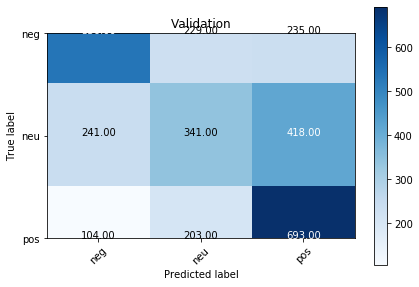

f1 score 0.5233333333333333


In [77]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=pred_labels)
plot_confusion_matrix(cm_test,
                      ['neg', 'neu', 'pos'],
                      normalize=False,
                      title='Validation')
print("f1 score", f1_score(df_tst["label"], pred_labels, average="micro"))

Now we can predict completely made up adhoc examples:

In [0]:
pred_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!"
]

In [79]:
predictions = get_prediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] that movie was absolutely awful [SEP]


INFO:tensorflow:tokens: [CLS] that movie was absolutely awful [SEP]


INFO:tensorflow:input_ids: 101 2008 3185 2001 7078 9643 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2008 3185 2001 7078 9643 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the acting was a bit lacking [SEP]


INFO:tensorflow:tokens: [CLS] the acting was a bit lacking [SEP]


INFO:tensorflow:input_ids: 101 1996 3772 2001 1037 2978 11158 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 3772 2001 1037 2978 11158 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the film was creative and surprising [SEP]


INFO:tensorflow:tokens: [CLS] the film was creative and surprising [SEP]


INFO:tensorflow:input_ids: 101 1996 2143 2001 5541 1998 11341 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 2143 2001 5541 1998 11341 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] absolutely fantastic ! [SEP]


INFO:tensorflow:tokens: [CLS] absolutely fantastic ! [SEP]


INFO:tensorflow:input_ids: 101 7078 10392 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 7078 10392 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/DeepLearning/english-large/models/model.ckpt-5593


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Voila! We have a sentiment classifier!

In [80]:
predictions[0][2]

1

In [81]:
predictions


[('That movie was absolutely awful',
  array([-2.6890805e-03, -6.3359408e+00, -6.9976740e+00], dtype=float32),
  1),
 ('The acting was a bit lacking',
  array([-3.5431213 , -0.03227618, -5.8646784 ], dtype=float32),
  3),
 ('The film was creative and surprising',
  array([-5.7396507 , -0.92527556, -0.5102227 ], dtype=float32),
  5),
 ('Absolutely fantastic!',
  array([-5.49177   , -5.7424636 , -0.00735433], dtype=float32),
  5)]

#5.0 Save the model for later use

1. just from checkpoint (which requires the architecture as the checkpoints only contain the parameters/weights)

2. as the complete model

In [0]:
# trying to save the model, and read it in.
